In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

In [ ]:
# binaries from here:
# http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/AJ/142/160/v3

# double x-matched to Gaia DR2 & B-J Distances

In [34]:
file = '1540938945496A.csv'
df = pd.read_csv(file)

df.columns

Index(['angDist', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest', 'B_rest',
       'rlen', 'ResFlag', 'ModFlag', 'angDist.1', 'ra_epoch2000',
       'dec_epoch2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'source_id',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       '_RAJ2000', '_DEJ2000', 'KIC', 'Per', 'BJD0', 'Morph', 'SC', 'LC', 'T3',
       'Simbad', '_RA', '_DE'],
      dtype='object')

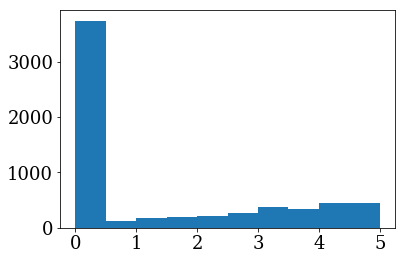

In [35]:
_ = plt.hist(df['angDist'])

In [53]:
# ok = ((df['angDist'] < 0.3) & (df['parallax_error'] / df['parallax'] < 0.05) & 
#       (df['phot_g_mean_flux_error'] / df['phot_g_mean_flux'] < 0.01))

ok = np.where(np.isfinite(df['parallax']) & # this is basically the same as the TGAS file...
              (df['parallax_error'] < 0.1) &
              (df['ModFlag'] == 1) & 
              (df['ResFlag'] == 1) &
              np.isfinite(df['bp_rp']) & 
              (df['phot_bp_mean_flux_error']/df['phot_bp_mean_flux'] < 0.01) & 
              (df['phot_rp_mean_flux_error']/df['phot_rp_mean_flux'] < 0.01) & 
              (df['phot_g_mean_flux_error']/df['phot_g_mean_flux'] < 0.01))[0]
ok.shape # this is most of the true EBs

(2857,)

Text(0.5,1,'Kepler EBs')

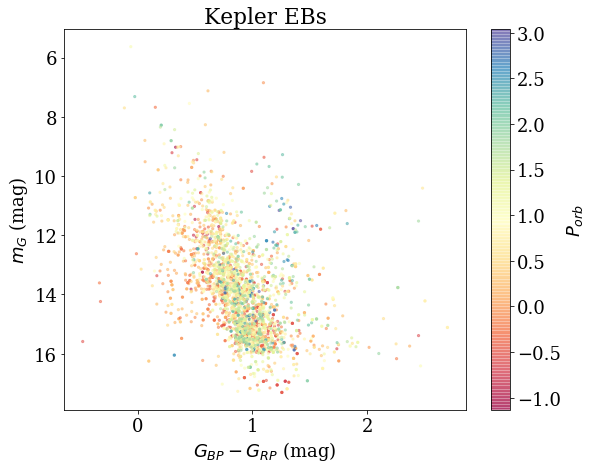

In [54]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral

plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok], 
            c=np.log10(df['Per'][ok]), cmap=cmap, s=5, alpha=0.5)
plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('$P_{orb}$')
plt.ylabel('$m_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Kepler EBs')

In [76]:
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = 'MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'

mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

# mist_ms1 = np.where((mist['phase']==0) & 
#                     (mist['log10_isochrone_age_yr'] == 9.) & 
#                     (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]

mist_ms1 = np.where((mist['phase'] < 5) & (mist['log10_isochrone_age_yr'] == 9.))[0][::-1]

Text(0.5,1,'Kepler EBs')

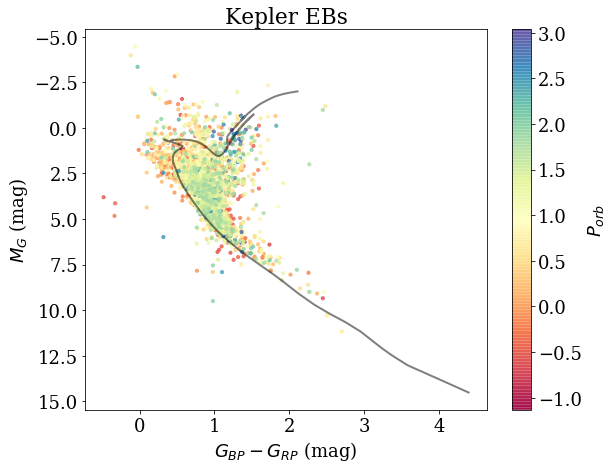

In [77]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral

plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=10)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.5)

plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('$P_{orb}$')
plt.ylabel('$M_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Kepler EBs')